## A simple Autoencoder to be trained on GPU/CPU 

### Aimed at compressing Stokes I (for now) for synthesized observed photospheric spectral lines 

### various training and validation sets available at: 

https://drive.google.com/drive/folders/1SO4FyyX_X878FAcU7k1zD6AkOvFyWMH4?usp=sharing

In [1]:
# Initial imports

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchsummary import summary #https://github.com/sksq96/pytorch-summary
torch.manual_seed(1234)
np.random.seed(1234)

In [2]:
# We are going to make a dense autoencoder here:


class dense_ae(nn.Module):
    def __init__(self, inputsize, bottleneck):
        super(dense_ae, self).__init__()
        self.linear1 = nn.Linear(inputsize,80)
        self.activation = nn.ReLU()
        self.activationS = nn.Sigmoid()
        self.linear2 = nn.Linear(80,40)
        self.linear3 = nn.Linear(40, bottleneck)
        self.linear4 = nn.Linear(bottleneck,40)
        self.linear5 = nn.Linear(40,80)
        self.linear6 = nn.Linear(80,inputsize)
        
    def forward(self, x):
        out = self.linear1(x)
        out = self.activationS(out)
        out = self.linear2(out)
        out = self.activationS(out)
        out = self.linear3(out)
        out = self.activationS(out)
        out = self.linear4(out)
        out = self.activationS(out)
        out = self.linear5(out)
        out = self.activationS(out)
        out = self.linear6(out)
        out = self.activationS(out)
        
        #out = out.view(out.size(0), -1)
        #return self.linear3(out)
        
        return out
    
def make_model(cudaoption, inputsize, bottleneck):
    
    model = dense_ae(inputsize, bottleneck)
    
    if (cudaoption):
        print('[INFO] Cuda model:',torch.cuda.get_device_name(0))
        model = model.to(device)
        
        print('[INFO] Parameters in GPU:',next(model.parameters()).is_cuda) 
        
    return model   

def model_predict(model, inputdata, cudaoption):
    
    if cudaoption:
        
        model = model.to(device)
        inputdata = inputdata.to(device)
        
    output = model.forward(inputdata)
    
    output = output.to("cpu")
    return output

In [3]:
# test for GPU:

cudaoption = torch.cuda.is_available()
device = torch.device("cuda:0" if cudaoption else "cpu")
print('[INFO] Cuda:', cudaoption)
print('[INFO] Cuda device:', device)

[INFO] Cuda: True
[INFO] Cuda device: cuda:0


In [4]:
ae_model = make_model(cudaoption, 201, 15)

[INFO] Cuda model: NVIDIA GeForce RTX 3060 Ti
[INFO] Parameters in GPU: True


### Ok, creating the model and making sure GPU works is done, now let's see what happens with data.

In [5]:
from astropy.io import fits 

In [33]:
stokes = fits.open("C:/Data/6300_compression_training/50G.ngrey.288x100x288_atmos_61_synth.fits")[0].data

In [34]:
stokes.shape

(288, 288, 4, 601)

In [35]:
stokes = stokes[:,:,0,100:-100]
print (stokes.shape)
stokes = stokes[:,:,::2]
print (stokes.shape)
data = stokes.reshape(288*288,201)

(288, 288, 401)
(288, 288, 201)


In [9]:
del(stokes)

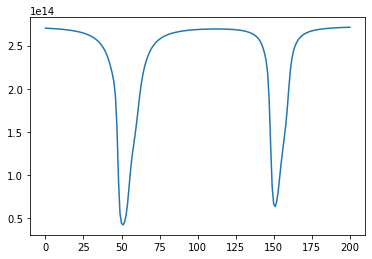

In [10]:
plt.plot(data[0])

In [11]:
data_norm = np.copy(data)

In [12]:
# If you want to normalize wavelength wise (not a good idea imho)

#for l in range(0,201):
#    data_norm[:,l] = (data[:,l] - np.amin(data[:,l])) / (np.amax(data[:,l])-np.amin(data[:,l]))

In [13]:
dmax = np.amax(data)
dmin = np.amin(data)

In [14]:
data_norm[:,:] = (data[:,:] - np.amin(data[:,:])) / (np.amax(data[:,:])-np.amin(data[:,:]))

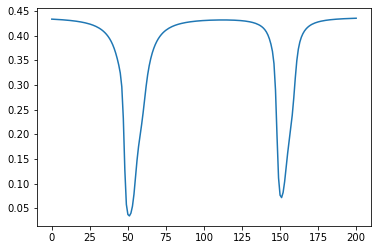

In [15]:
plt.plot(data_norm[0])

In [16]:
del(data)

In [17]:
data_torch = torch.from_numpy(data_norm.astype('float32'))

In [18]:
test_output = model_predict(ae_model,data_torch[:10],cudaoption)

In [19]:
test_output.shape

torch.Size([10, 201])

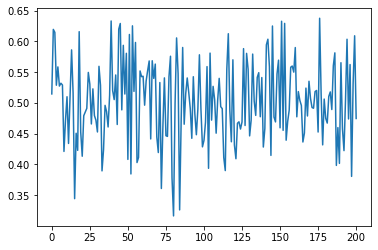

In [20]:
plt.plot(test_output[0].detach().numpy())

In [21]:
## Let's make a function to train:

def compilefit(model, data, nepochs, criterion, cudaoption, lri, output_interval):
    
    optimizer = torch.optim.Adam(model.parameters(), lr = lri)
    loss_fn = nn.MSELoss()
    
    if cudaoption:
        data = data.to(device)
        
    performance = np.zeros(nepochs)
            
    for i in range(0,nepochs):
        
        optimizer.zero_grad()
        out = model.forward(data)
             
        loss = loss_fn(data,out)
        loss.backward()
        optimizer.step()
        performance[i] = loss.item()
        if i%int(output_interval)==0: print(f' It : {i:3d} - loss : {loss.item():.6f} - residual std : {np.sqrt(loss.item()):.6f}')
    return performance

In [22]:
# Create model again as the above was just testing:
ae_model = make_model(cudaoption, 201, 10)

[INFO] Cuda model: NVIDIA GeForce RTX 3060 Ti
[INFO] Parameters in GPU: True


In [23]:
summary(ae_model,input_size=(1,201))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 80]          16,160
           Sigmoid-2                [-1, 1, 80]               0
            Linear-3                [-1, 1, 40]           3,240
           Sigmoid-4                [-1, 1, 40]               0
            Linear-5                [-1, 1, 10]             410
           Sigmoid-6                [-1, 1, 10]               0
            Linear-7                [-1, 1, 40]             440
           Sigmoid-8                [-1, 1, 40]               0
            Linear-9                [-1, 1, 80]           3,280
          Sigmoid-10                [-1, 1, 80]               0
           Linear-11               [-1, 1, 201]          16,281
          Sigmoid-12               [-1, 1, 201]               0
Total params: 39,811
Trainable params: 39,811
Non-trainable params: 0
---------------------------------

In [24]:
nepochs = 200000

convergence = compilefit(ae_model, data_torch, nepochs, 0, cudaoption, 5E-3, 1000)

 It :   0 - loss : 0.032235 - residual std : 0.179542
 It : 1000 - loss : 0.001254 - residual std : 0.035413
 It : 2000 - loss : 0.000953 - residual std : 0.030870
 It : 3000 - loss : 0.000426 - residual std : 0.020632
 It : 4000 - loss : 0.000368 - residual std : 0.019186
 It : 5000 - loss : 0.000387 - residual std : 0.019662
 It : 6000 - loss : 0.000377 - residual std : 0.019407
 It : 7000 - loss : 0.000335 - residual std : 0.018300
 It : 8000 - loss : 0.000338 - residual std : 0.018397
 It : 9000 - loss : 0.000459 - residual std : 0.021422
 It : 10000 - loss : 0.000320 - residual std : 0.017901
 It : 11000 - loss : 0.000431 - residual std : 0.020761
 It : 12000 - loss : 0.000185 - residual std : 0.013587
 It : 13000 - loss : 0.000161 - residual std : 0.012707
 It : 14000 - loss : 0.000148 - residual std : 0.012147
 It : 15000 - loss : 0.000109 - residual std : 0.010441
 It : 16000 - loss : 0.000096 - residual std : 0.009780
 It : 17000 - loss : 0.000111 - residual std : 0.010542
 It

 It : 146000 - loss : 0.000013 - residual std : 0.003563
 It : 147000 - loss : 0.000012 - residual std : 0.003415
 It : 148000 - loss : 0.000013 - residual std : 0.003544
 It : 149000 - loss : 0.000013 - residual std : 0.003556
 It : 150000 - loss : 0.000013 - residual std : 0.003667
 It : 151000 - loss : 0.000012 - residual std : 0.003528
 It : 152000 - loss : 0.000032 - residual std : 0.005673
 It : 153000 - loss : 0.000018 - residual std : 0.004257
 It : 154000 - loss : 0.000013 - residual std : 0.003608
 It : 155000 - loss : 0.000023 - residual std : 0.004847
 It : 156000 - loss : 0.000013 - residual std : 0.003612
 It : 157000 - loss : 0.000013 - residual std : 0.003562
 It : 158000 - loss : 0.000030 - residual std : 0.005465
 It : 159000 - loss : 0.000027 - residual std : 0.005240
 It : 160000 - loss : 0.000014 - residual std : 0.003787
 It : 161000 - loss : 0.000016 - residual std : 0.003990
 It : 162000 - loss : 0.000012 - residual std : 0.003533
 It : 163000 - loss : 0.000017 

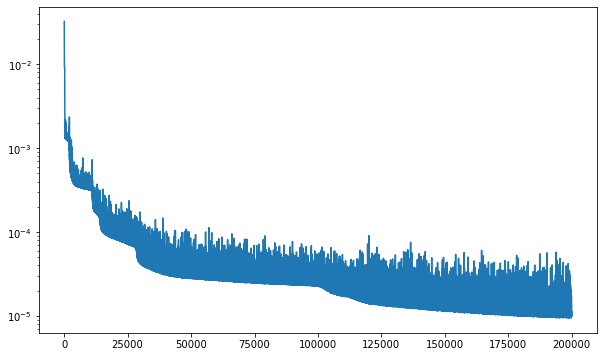

In [25]:
plt.figure(figsize=[10,6])
plt.semilogy(convergence)

In [26]:
test_train = test_output = model_predict(ae_model,data_torch[:10],cudaoption)
test_train.shape

torch.Size([10, 201])

In [27]:
bla = test_train.detach().numpy()

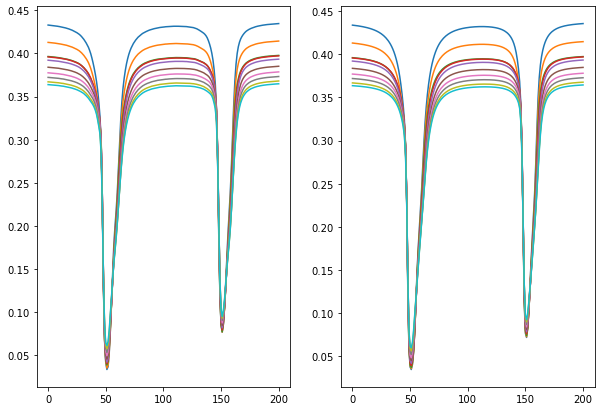

In [28]:
plt.figure(figsize=[10,7])
plt.subplot(121)
for i in range(0,10):
    plt.plot(bla[i])
plt.subplot(122)
for i in range(0,10):
    plt.plot(data_norm[i])



### Here we do some statistical analysis of the "compression"

In [29]:
test_output = model_predict(ae_model,data_torch,cudaoption)

In [30]:
data_reconstructed = test_output.detach().numpy()

In [31]:
# de-normalize

data_reconstructed  = data_reconstructed * (dmax-dmin) + dmin

In [36]:
noise = np.mean(data[:,0]) * 7E-3

residual = (data - data_reconstructed)
residual /= noise
residual = residual**2.0
print (len(residual))
chisq = np.sum(residual,axis=1) / 201
print (np.mean(chisq))
print (np.median(chisq))

82944
0.7025463608800483
0.3964251771522226


(array([  27., 2614., 9825., 9773., 8606., 6933., 5891., 4842., 3992.,
        3476., 2852., 2517., 2154., 1887., 1607., 1340., 1179., 1114.,
         946.,  794.,  726.,  676.,  576.,  536.,  499.,  394.,  421.,
         361.,  358.,  297.,  283.,  287.,  262.,  226.,  221.,  214.,
         167.,  173.,  161.,  155.,  123.,  133.,  125.,  121.,  116.,
         106.,  100.,  102.,  103.,   73.]),
 array([0.  , 0.06, 0.12, 0.18, 0.24, 0.3 , 0.36, 0.42, 0.48, 0.54, 0.6 ,
        0.66, 0.72, 0.78, 0.84, 0.9 , 0.96, 1.02, 1.08, 1.14, 1.2 , 1.26,
        1.32, 1.38, 1.44, 1.5 , 1.56, 1.62, 1.68, 1.74, 1.8 , 1.86, 1.92,
        1.98, 2.04, 2.1 , 2.16, 2.22, 2.28, 2.34, 2.4 , 2.46, 2.52, 2.58,
        2.64, 2.7 , 2.76, 2.82, 2.88, 2.94, 3.  ]),
 <BarContainer object of 50 artists>)

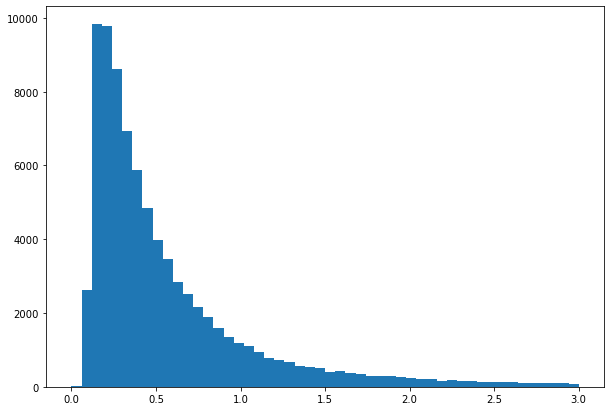

In [37]:
plt.figure(figsize=[10,7])
plt.hist(chisq,bins=50,range=[0,3])

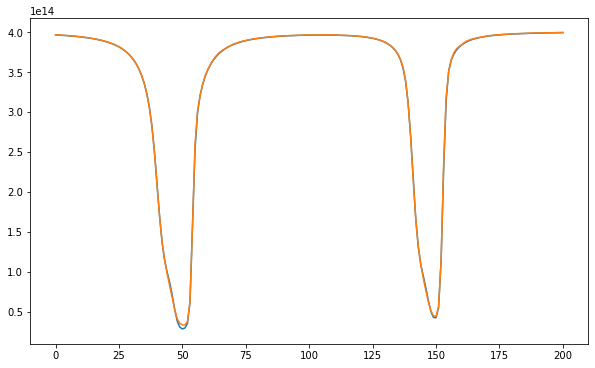

In [39]:
# Example plots 

i = 33337

plt.figure(figsize=[10,6])
plt.plot(data[i])
plt.plot(data_reconstructed[i])

### Simple validation here:

In [63]:
data_val = fits.open("C:/Data/6300_compression_training/andres_models_synth.fits")[0].data

In [64]:
data_val = data_val[:,:,0,100:-100]
data_val = data_val[:,:,::2]
print(data_val.shape)
data_val = data_val.reshape(288*288,201)

(288, 288, 201)


In [65]:
data_val = (data_val - dmin) / (dmax-dmin)

In [66]:
data_val = torch.from_numpy(data_val.astype('float32'))

In [67]:
data_val_predicted = model_predict(ae_model,data_val, cudaoption)

In [68]:
data_val_predicted = data_val_predicted.detach().numpy()
data_val = data_val.detach().numpy()

In [69]:
data_val_predicted = data_val_predicted * (dmax-dmin) + dmin
data_val = data_val * (dmax-dmin) + dmin

In [70]:
#noise = np.mean(data[:,0]) * 7E-3

residual = (data_val - data_val_predicted)
residual /= noise
residual = residual**2.0
print (len(residual))
chisq = np.sum(residual,axis=1) / 201
print (np.mean(chisq))
print (np.median(chisq))

82944
2.9622
0.8851936


(array([ 119., 2638., 5770., 6768., 6481., 6037., 5272., 4763., 4166.,
        3669., 3158., 2828., 2487., 2290., 1961., 1795., 1608., 1491.,
        1321., 1195., 1069.,  969.,  923.,  806.,  755.,  701.,  611.,
         582.,  507.,  512.,  433.,  409.,  383.,  369.,  332.,  332.,
         314.,  266.,  267.,  242.,  237.,  205.,  194.,  163.,  197.,
         169.,  145.,  146.,  138.,  120.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
        1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5,
        2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8,
        3.9, 4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. ],
       dtype=float32),
 <BarContainer object of 50 artists>)

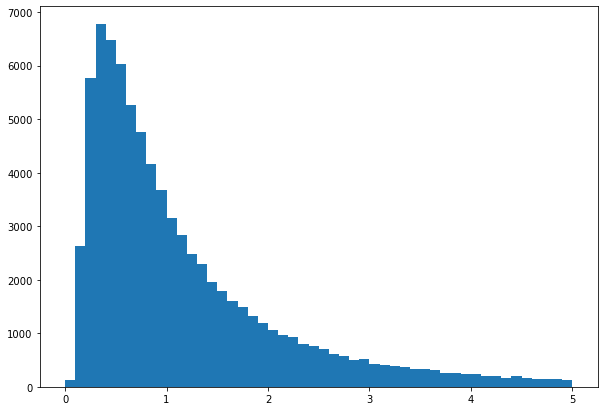

In [71]:
plt.figure(figsize=[10,7])
plt.hist(chisq,bins=50,range=[0,5])

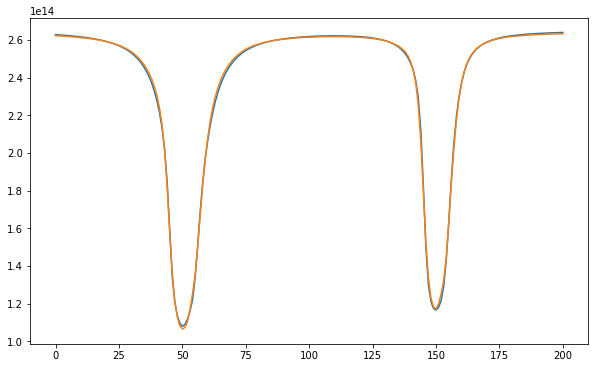

In [73]:
# Example plots 

i = 1313

plt.figure(figsize=[10,6])
plt.plot(data_val[i])
plt.plot(data_val_predicted[i])